> 18.3.29
* 8个 label 分别训练模型
* 使用 InceptionResNetV2 作为预训练模型
    * 切分数据集
        * 先使用 lr = 0.001 训练 6-8 个 epoch
        * 然后使用 lr = 0.0001 训练 1-3 个 epoch
        * 得到模型一
    * 不切分数据集
        * 使用全部训练集
        * 改变数据增强参数
        * lr = 0.0001 
        * 在模型一的基础上训练 10 个 epoch
        * 得到模型二
    * TTA 对模型一和二进行融合, 得到 v2 结果 
* 使用 Xception 作为预训练模型, 重复上面操作
    * 得到 xcep 结果
* 将 v2 结果和 xcep 结果进行融合


> 18.3.21
* 测试迁移学习 baseline
* https://github.com/DavexPro/fashion-tag/blob/master/transfer_learning.ipynb 进行复盘
* 在 baseline 的基础上进行 data_augmentation
* 增加混淆矩阵
* 增加误差分析

In [16]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据

* label 文件一共有 79572 行
* 各种维度混合在一起
* 我们的目的是切分开各种维度, 进行训练和模拟
* 那么首先取出个标签的图片进行聚类

In [3]:
df_train = pd.read_csv('../../raw/base/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
1,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
2,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
3,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn
4,Images/collar_design_labels/fd01ac6593f254a5dd...,collar_design_labels,ynnnn


In [4]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [5]:
cur_class = classes[0]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 8392


,image_id,class,label
0,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
1,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
2,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
3,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn
4,Images/collar_design_labels/fd01ac6593f254a5dd...,collar_design_labels,ynnnn


In [6]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

In [7]:
n_class

5

In [8]:
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread('../../raw/base/{0}'.format(df_load['image_id'][i])), (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 8392/8392 [01:11<00:00, 118.01it/s]


In [9]:
X.shape, y.shape

((8392, 299, 299, 3), (8392, 5))

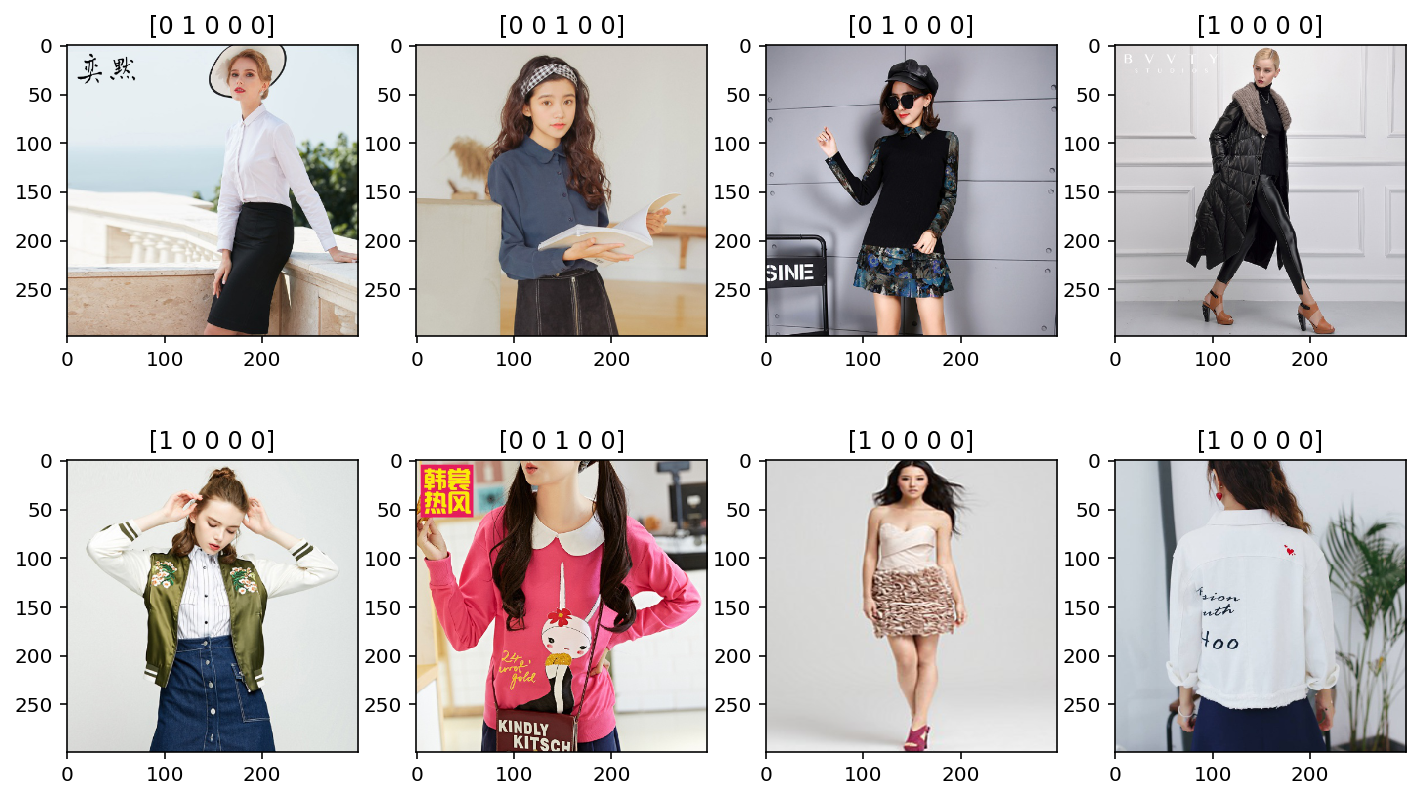

In [10]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

## 提取特征

In [11]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
import keras

Using TensorFlow backend.


In [12]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')

In [13]:
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [14]:
# for layer in cnn_model.layers[:-23]:
#     layer.trainable = False

## K-Fold 交叉验证

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
y_fake = np.zeros((n), dtype=np.uint8) # y 必须是 label 的 1-D array, 而不能是 one-hot 编码, 通过做一个假的 y 来得到, Index

In [76]:
# 切分数据集
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=42)
# X_train.shape, y_train.shape

((7384, 299, 299, 3), (7384, 5))

In [71]:
# Compile the model
adam = Adam(lr=0.001) 

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
# Set a learning rate annealer
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
#                                             patience=3,
#                                             verbose=1,
#                                             factor=0.1,
#                                             min_lr=0.00001)

In [73]:
epochs = 8
batch_size = 32

In [74]:
# X.shape, y.shape

## 数据增强

In [75]:
datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening = False, # apply ZCA whitening
        rotation_range = 10, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # randomly zoom image
        width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1, # randomly shift images vertivally (fraction of total heigth)
        horizontal_flip = True, # randomly flip images
        vertical_flip = False,
        shear_range = 0.1,
        fill_mode = 'constant',
        cval = 0)

# datagen.fit(X_train)

* 少量旋转
* 少量偏移
* 水平翻转
* 垂直翻转

In [ ]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

In [76]:
prefix_cls = cur_class.split('_')[0]

try:
    # Fit the model
    for j, (train_index, test_index) in enumerate(kfold.split(X, y_fake)):
        print('\nFold ',j)
        
        name_weights = "v2_fold" + str(j) + "{0}_weights.h5".format(prefix_cls)
        checkpointer = ModelCheckpoint(name_weights, verbose=1, 
                               save_best_only=True, monitor='val_loss', mode='min')
        
        # KFold 数据集
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        
        # 训练模型
        datagen.fit(X_train)
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                      epochs=epochs, validation_data=(X_valid, y_valid),
                                      verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
                                      callbacks=[EarlyStopping(patience=3), checkpointer])
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Epoch 1/32
KeyboardInterrupt


* 第一个参数是 loss, 第二个参数是 acc

## 测试模型

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 混淆矩阵

In [ ]:
## Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This fuction prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plt the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(n_class))

## 误差审查

In [ ]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

In [ ]:
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

In [ ]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((299, 299, 3)))
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1

In [ ]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_imaportant_errors = sorted_dela_errors[-12:]

# Show the top 6 errors
display_errors(most_imaportant_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 加载模型

In [23]:
df_test = pd.read_csv('../../raw/rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

,image_id,class
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels


In [24]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 1082


,image_id,class
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels


In [25]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('../../raw/rank/{0}'.format(df_load['image_id'][i])), (width, width))

100%|██████████| 1082/1082 [00:08<00:00, 123.55it/s]


In [19]:
'../../raw/rank/{0}'.format(df_load['image_id'][i])

'../../raw/rank/Images/collar_design_labels/bd0981f231180d2b001d4a37e9834630.jpg'

In [57]:
model.load_weights('./models/skirt_length_labels.best.h5')

In [32]:
test_np = model.predict(X_test, batch_size=256)

In [33]:
test_np.shape

(1082, 5)

In [35]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

,image_id,class,result
0,Images/collar_design_labels/60951f5761ea3a01d6...,collar_design_labels,0.0000;0.9985;0.0012;0.0002;0.0000
1,Images/collar_design_labels/677e1183282769a3fe...,collar_design_labels,0.0000;0.0000;0.0000;1.0000;0.0000
2,Images/collar_design_labels/3f5a2be205e5d253eb...,collar_design_labels,0.0000;0.9999;0.0000;0.0000;0.0000
3,Images/collar_design_labels/1712bf3d7b57d779ad...,collar_design_labels,0.0664;0.0325;0.4378;0.4517;0.0116
4,Images/collar_design_labels/0b2b4254f35ce3a41a...,collar_design_labels,0.0160;0.0492;0.0465;0.7992;0.0892


In [38]:
df_load.to_csv('./result/{}_0321a.csv'.format('collar'), header=None, index=False)